## 通过 MovieTweetings 创建推荐系统：协同过滤

**协同过滤**是最热门的推荐方法之一。在协同过滤中，我们利用用户-项目推荐的协同作用做出新的推荐。  

协同过滤的实现方法主要有两种：

1.**基于近邻的协同过滤**，原理是我们可以将相似的项目关联到一起并提供推荐，或者将用户关联到一起并提供推荐。

2.**基于模型的协同过滤**，原理是我们可以利用机器学习和其他数学模型了解项目和用户之间的关系，并预测评分和提供评分。


在此 notebook 中，你将实现**基于近邻的协同过滤**。协同过滤的实现方法主要有两种：

1.**基于用户的协同过滤：**在这种推荐系统中，我们根据与目标用户相关的用户向目标用户提供推荐内容。

2.**基于项目的协同过滤：**在这种推荐系统中，首先你需要（根据类似评分）查找相互之间关系最紧密的项目。然后根据用户对这些类似项目的评分了解此用户是否喜欢新的项目。

在此 notebook 中，你将实现**基于用户的协同过滤**。但是，很容易在此方法的基础上使用**基于项目的协同过滤**做出推荐。首先读取数据和必要的库。

**注意**：由于数据集很大，所以某些代码单元格可能需要执行一段时间，请耐心等待。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project_tests as t
from scipy.sparse import csr_matrix
from IPython.display import HTML


%matplotlib inline

# Read in the datasets
movies = pd.read_csv('movies_clean.csv')
reviews = pd.read_csv('reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']

print(reviews.head())

   user_id  movie_id  rating   timestamp                 date  month_1  \
0        1     68646      10  1381620027  2013-10-12 23:20:27        0   
1        1    113277      10  1379466669  2013-09-18 01:11:09        0   
2        2    422720       8  1412178746  2014-10-01 15:52:26        0   
3        2    454876       8  1394818630  2014-03-14 17:37:10        0   
4        2    790636       7  1389963947  2014-01-17 13:05:47        0   

   month_2  month_3  month_4  month_5  ...  month_9  month_10  month_11  \
0        0        0        0        0  ...        0         1         0   
1        0        0        0        0  ...        0         0         0   
2        0        0        0        0  ...        0         1         0   
3        0        0        0        0  ...        0         0         0   
4        0        0        0        0  ...        0         0         0   

   month_12  year_2013  year_2014  year_2015  year_2016  year_2017  year_2018  
0         0          1  

### 衡量相似性

在使用基于**近邻**的协同过滤时，了解如何衡量用户或项目之间的相似性很重要。  

我们可以通过多种方式衡量两个向量（可能是两个用户或两个项目）之间的相似性。在此 notebook 中，我们将学习两种比较向量的衡量方法：

* **皮尔逊相关系数**

皮尔逊相关系数衡量的是线性关系的强度和方向。此系数的值始终位于 -1-1 之间，其中 -1 表示很强的负线性关系，1 表示很强的正线性关系。 

假设有两个向量 x 和 y，我们可以如下所示地定义这两个向量之间的关系：


$$CORR(x, y) = \frac{\text{COV}(x, y)}{\text{STDEV}(x)\text{ }\text{STDEV}(y)}$$

其中 

$$\text{STDEV}(x) = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2}$$

并且 

$$\text{COV}(x, y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})$$

其中 n 表示向量的长度，x 和 y 的长度必须相同，$\bar{x}$ 表示向量中观察值的均值。  

我们可以使用相关系数表示两个向量之间的相似度，系数越接近 1，则向量越相似。使用这种指标衡量相似性可能存在一些不足之处。你将在此 workbook 中看到一些不足。


* **欧几里得距离**

欧几里得距离衡量的是向量之间的直线距离。因为衡量的是距离，所以值越大，两个向量越不相似（与皮尔逊相关系数不同）。

具体而言，两个向量 x 和 y 之间的欧几里得距离公式如下：

$$ \text{EUCL}(x, y) = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$

与相关系数不同，我们不会对分母进行值范围调整。所以，在使用此指标时，所有数据的值范围都应该一样。

**注意：**因为衡量相似性经常都要查看向量之间的距离，所以必须要调整数据范围，或使所有数据位于同一范围内。如果某些衡量方法 5 分制，而其他方法是 100 分制，那么很有可能会出现非优结果，因为特征的变化性有差异。在我们的示例中，我们不需要调整数据范围，因为它们都是 10 分制，但是务必要记住这一点。

------------

### 用户-项目矩阵

为了计算相似性，我们通常会将值放入矩阵中。在以下矩阵中，每行表示一位用户，每列表示一项。  


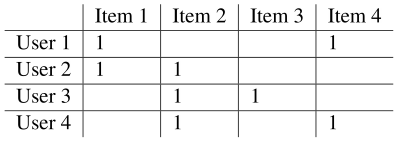


在上述矩阵中，**用户 1** 和**用户2** 都使用了**项目 1**，**用户 2** 和**用户 3** 及**用户 4** 都使用了**项目 2**。但是，矩阵中还缺少尚未使用某个项目的用户对应的很多值。缺少很多值的矩阵（例如上述矩阵）称为**稀疏矩阵**。

此 notebook 的第一个目标是使用 **reviews** 数据集创建上述矩阵。但是，每个单元格里不再是值 1，而是实际评分。  

每行表示一位用户，每列表示一部电影。为了创建用户-项目矩阵，我们只需 **reviews** DataFrame 的前三列，运行以下单元格就能看到这些列。

In [2]:
user_items = reviews[['user_id', 'movie_id', 'rating']]
user_items.head()

,user_id,movie_id,rating
0,1,68646,10
1,1,113277,10
2,2,422720,8
3,2,454876,8
4,2,790636,7


### 创建用户-项目矩阵

为了创建用户-项目矩阵（例如上述矩阵），我首先将使用[数据透视表](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html)。 

但是，我很快遇到了内存错误（此 notebook 不断提到的一个错误）。我将介绍下我遇到的很多错误，帮助你实现有用的协同过滤结果。 

_____

`1.` 创建一个矩阵，每行表示一位用户，每列表示一部电影，每个单元格存储了一个评分，如果用户尚未评分，则用 NaN 表示。如果你像我一样遇到内存错误，请参阅[此链接](https://stackoverflow.com/questions/39648991/pandas-dataframe-pivot-memory-error)。

In [3]:
# Create user-by-item matrix
user_by_movie = user_items.groupby(['user_id', 'movie_id'])['rating'].max().unstack()

请在以下单元格中检查你的结果，并为后续部分准备好你的矩阵。

In [4]:
assert movies.shape[0] == user_by_movie.shape[1], "Oh no! Your matrix should have {} columns, and yours has {}!".format(movies.shape[0], user_by_movie.shape[1])
assert reviews.user_id.nunique() == user_by_movie.shape[0], "Oh no! Your matrix should have {} rows, and yours has {}!".format(reviews.user_id.nunique(), user_by_movie.shape[0])
print("Looks like you are all set! Proceed!")

Looks like you are all set! Proceed!


`2.` 创建好用户-电影矩阵后，使用此矩阵创建一个字典，每位用户表示键，每位用户评过分的电影数组表示值。

In [5]:
# Create a dictionary with users and corresponding movies seen

def movies_watched(user_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    OUTPUT:
    movies - an array of movies the user has watched
    '''
    movies = user_by_movie.loc[user_id][user_by_movie.loc[user_id].isnull() == False].index.values

    return movies


def create_user_movie_dict():
    '''
    INPUT: None
    OUTPUT: movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids
    
    Creates the movies_seen dictionary
    '''
    n_users = user_by_movie.shape[0]
    movies_seen = dict()

    for user1 in range(1, n_users+1):
        
        # assign list of movies to each user key
        movies_seen[user1] = movies_watched(user1)
    
    return movies_seen
    
movies_seen = create_user_movie_dict()

`3.` 如果用户评分的电影不超过 2 部，则将这些用户视为“全新”用户。创建一个新的字典，其中仅包含评分的电影超过 2 部的用户。在此 workbook 的所有后续步骤中，我们将使用此字典。

In [6]:
# Remove individuals who have watched 2 or fewer movies - don't have enough data to make recs

def create_movies_to_analyze(movies_seen, lower_bound=2):
    '''
    INPUT:  
    movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids
    lower_bound - (an int) a user must have more movies seen than the lower bound to be added to the movies_to_analyze dictionary

    OUTPUT: 
    movies_to_analyze - a dictionary where each key is a user_id and the value is an array of movie_ids
    
    The movies_seen and movies_to_analyze dictionaries should be the same except that the output dictionary has removed 
    
    '''
    movies_to_analyze = dict()

    for user, movies in movies_seen.items():
        if len(movies) > lower_bound:
            movies_to_analyze[user] = movies
    return movies_to_analyze

movies_to_analyze = create_movies_to_analyze(movies_seen)

In [7]:
# Run the tests below to check that your movies_to_analyze matches the solution
assert len(movies_to_analyze) == 23512, "Oops!  It doesn't look like your dictionary has the right number of individuals."
assert len(movies_to_analyze[2]) == 23, "Oops!  User 2 didn't match the number of movies we thought they would have."
assert len(movies_to_analyze[7])  == 3, "Oops!  User 7 didn't match the number of movies we thought they would have."
print("If this is all you see, you are good to go!")

If this is all you see, you are good to go!


### 计算用户相似度

设置好 **movies_to_analyze** 字典后，我们来进一步了解用户之间的相似性。下面这段伪代码表示我计算用户相似度的思路：

```
for user1 in movies_to_analyze
    for user2 in movies_to_analyze
        see how many movies match between the two users
        if more than two movies in common
            pull the overlapping movies
            compute the distance/similarity metric between ratings on the same movies for the two users
            store the users and the distance metric
```

但是，运行时间很长，并且其他执行这些操作的方法在workspace 中占用的内存太多。

所以，我们不再创建一个包含数据集中所有可能的用户对数据，你的下个任务是查看两个用户的评分之间的几个特定关系示例。对于此问题，你需要计算用户之间的[相关性](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html)。

`4.` 请使用 **movies_to_analyze** 字典和 **user_by_movie** DataFrame 创建一个函数，该函数会计算两个用户对相似电影的评分之间的相关性。然后使用以下测试将你的函数结果与我们的结果进行比较。

In [8]:
def compute_correlation(user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the correlation between the matching ratings between the two users
    '''
    # Pull movies for each user
    movies1 = movies_to_analyze[user1]
    movies2 = movies_to_analyze[user2]
    
    
    # Find Similar Movies
    sim_movs = np.intersect1d(movies1, movies2, assume_unique=True)
    
    # Calculate correlation between the users
    df = user_by_movie.loc[(user1, user2), sim_movs]
    corr = df.transpose().corr().iloc[0,1]
    
    return corr #return the correlation

In [9]:
# Test your function against the solution
assert compute_correlation(2,2) == 1.0, "Oops!  The correlation between a user and itself should be 1.0."
assert round(compute_correlation(2,66), 2) == 0.76, "Oops!  The correlation between user 2 and 66 should be about 0.76."
assert np.isnan(compute_correlation(2,104)), "Oops!  The correlation between user 2 and 104 should be a NaN."

print("If this is all you see, then it looks like your function passed all of our tests!")

If this is all you see, then it looks like your function passed all of our tests!


### 为何有 NaN？

如果你的函数通过了所有测试，那么你的函数设置正确，能够计算任何两位用户之间的相关性。  

`5.` 但有一个问题是，为何依然出现 **NaN** 值？从上面的代码单元格中可以看到，用户 2 和用户 104 之间的关系为 **NaN**。为何？

请思考并解释为何存在这些 NaN，然后在以下单元格中编写代码来验证你的想法。你可以检查其他用户对，你会发现数据中有很多 NaN，实际上有 2,526,710 个。这些 NaN 最终导致该相关系数不是衡量两位用户之间相似性的最佳方法。

> In the denominator of the correlation coefficient, we calculate the standard deviation for each user's ratings.  The ratings for user 2 are all the same rating on the movies that match with user 104.  Therefore, the standard deviation is 0.  Because a 0 is in the denominator of the correlation coefficient, we end up with a **NaN** correlation coefficient.  Therefore, a different approach is likely better for this particular situation.

In [10]:
# Which movies did both user 2 and user 104 see?
set_2 = set(movies_to_analyze[2])
set_104 = set(movies_to_analyze[104])
set_2.intersection(set_104)

{454876, 816711, 1454468, 1535109}

In [11]:
# What were the ratings for each user on those movies?
print(user_by_movie.loc[2, set_2.intersection(set_104)])
print(user_by_movie.loc[104, set_2.intersection(set_104)])

movie_id
454876     8.0
1454468    8.0
1535109    8.0
816711     8.0
Name: 2, dtype: float64
movie_id
454876     9.0
1454468    7.0
1535109    9.0
816711     7.0
Name: 104, dtype: float64


`6.` 因为我们发现相关系数不是衡量用户之间评分关系的最佳方法，所以我们可以计算评分之间的欧几里得距离。在创建函数时，我发现[这篇帖子](https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy)很有用。这个函数应该与之前的函数很相似。当你对自己编写的函数很满意后，请与我们的结果进行比较。

In [12]:
def compute_euclidean_dist(user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the euclidean distance between user1 and user2
    '''
    # Pull movies for each user
    movies1 = movies_to_analyze[user1]
    movies2 = movies_to_analyze[user2]
    
    
    # Find Similar Movies
    sim_movs = np.intersect1d(movies1, movies2, assume_unique=True)
    
    # Calculate euclidean distance between the users
    df = user_by_movie.loc[(user1, user2), sim_movs]
    dist = np.linalg.norm(df.loc[user1] - df.loc[user2])
    
    return dist #return the euclidean distance

In [13]:
# Read in solution euclidean distances"
import pickle
#df_dists = pd.read_pickle("dists.p")
#df_dists.to_pickle('df_dists.p.xz', compression='xz')
#原始文件1G,压缩保存,大小为50+M
#本段代码只需运行一遍

In [19]:
# 读入较小文件
import pickle
df_dists = pd.read_pickle('df_dists.p.xz', compression='xz')

In [21]:
# Test your function against the solution
assert compute_euclidean_dist(2,2) == df_dists.query("user1 == 2 and user2 == 2")['eucl_dist'][0], "Oops!  The distance between a user and itself should be 0.0."
assert round(compute_euclidean_dist(2,66), 2) == round(df_dists.query("user1 == 2 and user2 == 66")['eucl_dist'][1], 2), "Oops!  The distance between user 2 and 66 should be about 2.24."
assert np.isnan(compute_euclidean_dist(2,104)) == np.isnan(df_dists.query("user1 == 2 and user2 == 104")['eucl_dist'][4]), "Oops!  The distance between user 2 and 104 should be 2."

print("If this is all you see, then it looks like your function passed all of our tests!")

If this is all you see, then it looks like your function passed all of our tests!


### 使用最近邻做出推荐。

在上个问题中，你读取了 **df_dists**。所以你获得了每位用户与其他每位用户之间的距离。此 DataFrame 存储了所有可能的用户对，以及对应的欧几里得距离。

之前已经讨论过，很多用户对的评分之间关系为 **NaN** 值，所以我们将继续使用 **df_dists**。你需要查找每位用户的最近邻用户。然后，你需要查找最近邻用户喜欢的电影，从而向每位用户推荐电影。

我使用了以下对象：

* df_dists（获取近邻）
* user_items（获取近邻和用户评分的电影）
* movies（获取电影片名）

`7.` 以下函数可以帮助你向任何用户推荐电影，请完成这些函数。你需要用到 5 个函数：

* **find_closest_neighbors** - 使用欧几里得距离返回从最近邻到最远邻的 user_id 列表


* **movies_liked** - 返回一个 movie_id 数组


* **movie_names** - 获取 movies_liked 的输出并返回一个与 movie_id 相关的电影片名列表


* **make_recommendations** - 获取一个user_id 并查看最近邻用户，然后返回电影片名列表作为推荐内容


* **all_recommendations** = 遍历每位用户并返回一个字典，键是 user_id，值是电影推荐列表

In [25]:
def find_closest_neighbors(user):
    '''
    INPUT:
        user - (int) the user_id of the individual you want to find the closest users
    OUTPUT:
        closest_neighbors - an array of the id's of the users sorted from closest to farthest away
    '''
    # I treated ties as arbitrary and just kept whichever was easiest to keep using the head method
    # You might choose to do something less hand wavy
    
    closest_users = df_dists[df_dists['user1']==user].sort_values(by='eucl_dist').iloc[1:]['user2']
    closest_neighbors = np.array(closest_users)
    
    return closest_neighbors
    
    
    
def movies_liked(user_id, min_rating=7):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    min_rating - the minimum rating considered while still a movie is still a "like" and not a "dislike"
    OUTPUT:
    movies_liked - an array of movies the user has watched and liked
    '''
    movies_liked = np.array(user_items.query('user_id == @user_id and rating > (@min_rating -1)')['movie_id'])
    
    return movies_liked


def movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(movies[movies['movie_id'].isin(movie_ids)]['movie'])
   
    return movie_lst
    
    
def make_recommendations(user, num_recs=10):
    '''
    INPUT:
        user - (int) a user_id of the individual you want to make recommendations for
        num_recs - (int) number of movies to return
    OUTPUT:
        recommendations - a list of movies - if there are "num_recs" recommendations return this many
                          otherwise return the total number of recommendations available for the "user"
                          which may just be an empty list
    '''
    # I wanted to make recommendations by pulling different movies than the user has already seen
    # Go in order from closest to farthest to find movies you would recommend
    # I also only considered movies where the closest user rated the movie as a 9 or 10
    
    # movies_seen by user (we don't want to recommend these)
    movies_seen = movies_watched(user)
    closest_neighbors = find_closest_neighbors(user)
    
    # Keep the recommended movies here
    recs = np.array([])
    
    # Go through the neighbors and identify movies they like the user hasn't seen
    for neighbor in closest_neighbors:
        neighbs_likes = movies_liked(neighbor)
        
        #Obtain recommendations for each neighbor
        new_recs = np.setdiff1d(neighbs_likes, movies_seen, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) > num_recs-1:
            break
    
    # Pull movie titles using movie ids
    recommendations = movie_names(recs)
    
    return recommendations

def all_recommendations(num_recs=10):
    '''
    INPUT 
        num_recs (int) the (max) number of recommendations for each user
    OUTPUT
        all_recs - a dictionary where each key is a user_id and the value is an array of recommended movie titles
    '''
    
    # All the users we need to make recommendations for
    users = np.unique(df_dists['user1'])
    n_users = len(users)
    
    #Store all recommendations in this dictionary
    all_recs = dict()
    
    # Make the recommendations for each user
    for user in users:
        all_recs[user] = make_recommendations(user, num_recs)
    
    return all_recs

all_recs = all_recommendations(10)

In [26]:
# This loads our solution dictionary so you can compare results
#all_recs_sol = pd.read_pickle("all_recs.p")
#dict数据,用pd读取时间超长,pd无法压缩为pickle存储
#使用picle读取非常快
all_recs_sol = pickle.load(open("all_recs.p", "rb"))

In [38]:
assert all_recs[2] == make_recommendations(2), "Oops!  Your recommendations for user 2 didn't match ours."
assert all_recs[26] == make_recommendations(26), "Oops!  It actually wasn't possible to make any recommendations for user 26."
assert all_recs[1503] == make_recommendations(1503), "Oops! Looks like your solution for user 1503 didn't match ours."
print("If you made it here, you now have recommendations for many users using collaborative filtering!")

If you made it here, you now have recommendations for many users using collaborative filtering!


### 下一步？

如果你已经来到这一步，那么你已经成功地实现了使用协同过滤做出推荐的方法。 

`8.` 下面快速总结下使用协同过滤做出推荐的步骤。

In [30]:
# Check your understanding of the results by correctly filling in the dictionary below
a = "pearson's correlation and spearman's correlation"
b = 'item based collaborative filtering'
c = "there were too many ratings to get a stable metric"
d = 'user based collaborative filtering'
e = "euclidean distance and pearson's correlation coefficient"
f = "manhattan distance and euclidean distance"
g = "spearman's correlation and euclidean distance"
h = "the spread in some ratings was zero"
i = 'content based recommendation'

sol_dict = {
    'The type of recommendation system implemented here was a ...': d,
    'The two methods used to estimate user similarity were: ': e,
    'There was an issue with using the correlation coefficient.  What was it?': h
}

t.test_recs(sol_dict)

"That's right! All of your solutions look good!"

此外，我们仔细研究一下某些结果。为了检查你的结果，你需要读取两个解答文件，并且需要创建以下对象

* **df_dists** - 关于 user1、user2 的 DataFrame，表示这两个用户之间的欧几里得距离
* **all_recs_sol** - 包含所有推荐内容的字典（键 = 用户，值 = 推荐列表）  

`9.` 请在以下单元格中使用这两个对象填写该字典，并完成此 notebook。

In [31]:
a = 567
b = 1503
c = 1319
d = 1325
e = 2526710
f = 0
g = 'Use another method to make recommendations - content based, knowledge based, or model based collaborative filtering'

sol_dict2 = {
    'For how many pairs of users were we not able to obtain a measure of similarity using correlation?': e,
    'For how many pairs of users were we not able to obtain a measure of similarity using euclidean distance?': f,
    'For how many users were we unable to make any recommendations for using collaborative filtering?': c,
    'For how many users were we unable to make 10 recommendations for using collaborative filtering?': d,
    'What might be a way for us to get 10 recommendations for every user?': g   
}

t.test_recs2(sol_dict2)

"That's right! All of your solutions look good!"

In [32]:
# Use the cells below for any work you need to do!

In [33]:
# Users without recs
users_without_recs = []
for user, movie_recs in all_recs.items():
    if len(movie_recs) == 0:
        users_without_recs.append(user)
    
len(users_without_recs)

1319

In [34]:
# NaN euclidean distance values
df_dists['eucl_dist'].isnull().sum()

0

In [35]:
# Users with fewer than 10 recs
users_with_less_than_10recs = []
for user, movie_recs in all_recs.items():
    if len(movie_recs) < 10:
        users_with_less_than_10recs.append(user)
    
len(users_with_less_than_10recs)

1325